# Load finetuned Pix2Struct model

In [ ]:
import torch
from transformers import AutoProcessor, Pix2StructForConditionalGeneration

processor = AutoProcessor.from_pretrained("oroikon/ft_pix2struct_chart_captioning")
model = Pix2StructForConditionalGeneration.from_pretrained("oroikon/ft_pix2struct_chart_captioning")

device = "cuda" if torch.cuda.is_available() else "cpu"
_ = model.to(device)

# Load test dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset('hk-kaden-kim/pix2struct-chartcaptioning')
eval_datasets = dataset['test']

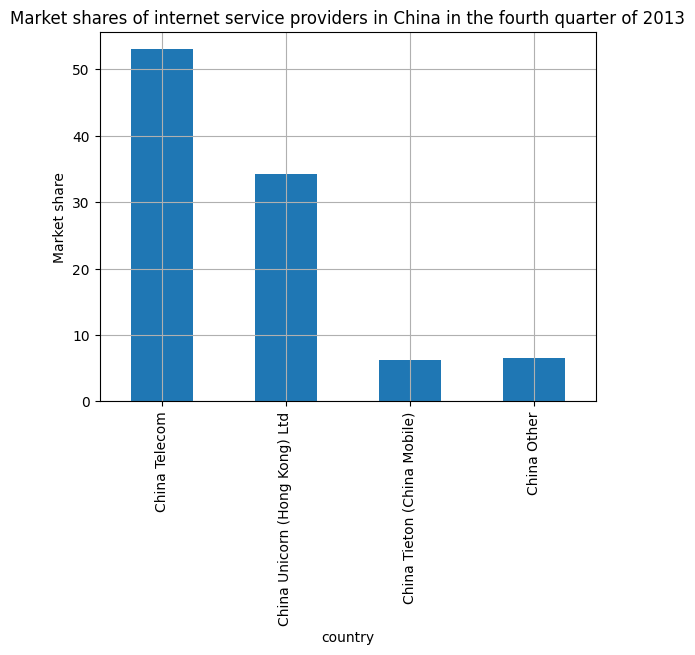

In [5]:
eval_datasets[0]["image"]

# Generate caption and save it with the metadata of test dataset

In [ ]:
import pandas as pd
from tqdm import tqdm

results = {"image_id":[], "gen_caption":[], "ref_caption":[], "chartType":[], "chartElement":[], "dataType":[],}
for idx in tqdm(range(eval_datasets.shape[0])):
    # print(idx)
    try:
      image = eval_datasets[idx]["image"]
      reference = eval_datasets[idx]["caption"]
      chart_type = eval_datasets[idx]["chartType"]
      chart_element = eval_datasets[idx]["chartElement"]
      data_type = eval_datasets[idx]["dataType"]

      # Image preprocessing and caption generation
      input_ids = processor(images=image, return_tensors="pt", max_patches=2048).to(device)
      flattened_patches = input_ids.flattened_patches
      attention_mask = input_ids.attention_mask
      generated_ids = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask, max_length=100)
      generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

      # generated_caption = reference
      results["image_id"] += [idx]
      results["gen_caption"] += [generated_caption]
      results["ref_caption"] += [reference]
      results["chartType"] += [chart_type]
      results["chartElement"] += [chart_element]
      results["dataType"] += [data_type]
    except Exception as e:
      print(f"Loading error! in {idx}")
      print(e)

    # if idx > 5:
    #     break

results_df = pd.DataFrame(results)
results_df.to_csv("./test_caption_gen.csv", index=False)